# Twitter Scraping & NLP

In [54]:
import requests 
import json
from config import consumer_key, consumer_secret, access_key, access_secret, bearer_token

import pandas as pd
import sys
import tweepy
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import time
import re
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import gensim
from gensim.parsing.preprocessing import remove_stopwords 

import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer

import nbformat

# Display max column width 
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/memme11/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/memme11/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/memme11/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/memme11/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/memme11/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Twitter API (Tweepy)

In [55]:
# Initialize and gain access to Twitter API
def initialize():
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    return api

api = initialize()

## Scrape Twitter Data

In [56]:
def scrape_twitter():
    
    search_words = ("bitcoin", "ethereum", "BNB", "NFT")
    crypto_data = pd.DataFrame()
    
    def get_data(data):
        data = {
            'text': data.full_text,
            'date': data.created_at,
            'followers': data.user.followers_count,
            'favourites': data.user.favourites_count,
            'retweets': data.retweet_count
        }
        return data
    
    for tweets in search_words:
        comp_tweets = api.search(q=tweets, lang = 'en', result_type = 'recent', count=250, tweet_mode='extended')
        
        for tweet in comp_tweets:
            row = get_data(tweet)
            crypto_data = crypto_data.append(row, ignore_index=True)
    
    
    # Formatting
    # Keep only tweets with over 1000 favourites
    crypto_data = crypto_data.loc[crypto_data['favourites']>1000]
    
    # Clean text column using Regex
    crypto_data['cleaned_text'] = crypto_data['text']
    clean_text = '(RT) @[\w]*:|(@[A-Za-z0-9]+)|([^\,\!\.\'\%0-9A-Za-z \t])|(\w+:\/\/\S+)'
    crypto_data['cleaned_text'] = crypto_data['cleaned_text'].str.replace(clean_text, " ", regex=True)
    crypto_data['cleaned_text'] = crypto_data['cleaned_text'].str.lower()
        
    # Convert date dtype to datetime, set index, sort index and drop duplicates
    crypto_data['date'] = pd.to_datetime(crypto_data['date'])
    crypto_data = crypto_data.set_index('date').sort_index(ascending=False)
    crypto_data.drop_duplicates(inplace=True)
    
    
    #Tokenizing
    # Tokenizing Functions
    def get_wordnet_pos(word):
        # Map POS tag to the first character lemmatize() accepts
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        
        return tag_dict.get(tag, wordnet.NOUN)
    
    # Function for tokenizing tweets (already cleaned using regex)
    def second_clean(tweet):
        tweet = remove_stopwords(tweet) # remove stopwords with Gensim
        
        lemmatizer = WordNetLemmatizer()
        tokenized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(tweet)]
        
        # remove left over stop words with nltk
        tokenized = [token for token in tokenized if token not in stopwords.words("english")] 
        
        # remove non-alpha characters and keep the words of length >2 only
        tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
        
        return tokenized
    
    # Function for joining tokenized list into string
    def combine_tokens(tokenized): 
        non_tokenized = ' '.join([w for w in tokenized])
        return non_tokenized
    
    # Execute token functions
    crypto_data['tokens'] = crypto_data['cleaned_text'].apply(lambda x: second_clean(x))
    crypto_data['final_clean'] = crypto_data['tokens'].apply(lambda x: combine_tokens(x))

    
    # NLP - Vader Sentiment Model 
    # Sentiment labels function 
    
    sia = SentimentIntensityAnalyzer()
    
    def sentiment_labels(df, feature, value): 
        df.loc[df[value] > 0,feature] = 'positive'
        df.loc[df[value] == 0,feature] = 'neutral'
        df.loc[df[value] < 0,feature] = 'negative'
    
    def vader_sentiment(df):
        target_col='cleaned_text'
        prefix = 'vader_clean_'
        
        scores_col=prefix+'scores'
        compound_col = prefix+'polarity'
        sentiment = prefix+'sentiment'
        
        df[scores_col] = df[target_col].apply(lambda x:sia.polarity_scores(x))
        df[compound_col] = df[scores_col].apply(lambda d: d['compound'])
        sentiment_labels(df, sentiment, compound_col)
    
    # Execute Vader Function
    vader_sentiment(crypto_data)
    
    return crypto_data

In [58]:
scrape_twitter()

,favourites,followers,retweets,text,cleaned_text,tokens,final_clean,vader_clean_scores,vader_clean_polarity,vader_clean_sentiment
date,,,,,,,,,,
2021-08-01 22:49:31,18899.0,25279.0,1.0,RT @timeehh: All Top Hat Chicks have been sold! other than the ones no one placed a bid $ETC $ADA $BCH\n\nI would like to thank everyone that…,all top hat chicks have been sold! other than the ones no one placed a bid etc ada bch i would like to thank everyone that,"[hat, chick, sell, one, place, bid, ada, bch, like, thank]",hat chick sell one place bid ada bch like thank,"{'neg': 0.07, 'neu': 0.703, 'pos': 0.227, 'compound': 0.5983}",0.5983,positive
2021-08-01 22:49:30,1706.0,105.0,183.0,RT @Nft_is_future: Our friends at @greatapesociety \nWould like to giveaway 1 @greatapesociety \n\nFollow @Nft_is_future \n @great…,our friends at would like to giveaway 1 follow is future,"[friend, like, giveaway, follow, future]",friend like giveaway follow future,"{'neg': 0.0, 'neu': 0.616, 'pos': 0.384, 'compound': 0.6808}",0.6808,positive
2021-08-01 22:49:30,2689.0,96.0,468.0,RT @ColeThereum: HOW TO MINT AN NFT DIRECTLY THROUGH THE SMART CONTRACT ON ETHERSCAN: ⬇️\n\nYou see those guys who mint 50 NFTs during a NFT…,how to mint an nft directly through the smart contract on etherscan you see those guys who mint 50 nfts during a nft,"[mint, nft, directly, smart, contract, etherscan, guy, mint, nfts, nft]",mint nft directly smart contract etherscan guy mint nfts nft,"{'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'compound': 0.4019}",0.4019,positive
2021-08-01 22:49:30,8630.0,2087.0,0.0,@some_onelse @StreetFighter Then you already have hold 1 ticket for the first raffle. There will be a raffle for each NFT. And multiple entries on all are allowed you can hold as many entries as you would like,onelse then you already have hold 1 ticket for the first raffle. there will be a raffle for each nft. and multiple entries on all are allowed you can hold as many entries as you would like,"[onelse, hold, ticket, raffle, raffle, nft, multiple, entry, allow, hold, entry, like]",onelse hold ticket raffle raffle nft multiple entry allow hold entry like,"{'neg': 0.0, 'neu': 0.935, 'pos': 0.065, 'compound': 0.3612}",0.3612,positive
2021-08-01 22:49:29,3026.0,492.0,6.0,"RT @Mastoooreh: THE SINGER\nYESSS \nI AM THE SINGER WHO WHISPER TO BRING U INTO MY WORLD , \nBE BRAVE\nCOME CLOSER\n\nCHECK OUT IN @opensea \n#NFT…","the singer yesss i am the singer who whisper to bring u into my world , be brave come closer check out in nft","[singer, yes, singer, whisper, bring, world, brave, come, closer, check, nft]",singer yes singer whisper bring world brave come closer check nft,"{'neg': 0.0, 'neu': 0.871, 'pos': 0.129, 'compound': 0.5267}",0.5267,positive
...,...,...,...,...,...,...,...,...,...,...
2021-08-01 22:46:33,43337.0,382.0,83.0,RT @Coin98Analytics: Can you name an alternative Ethereum #Layer2 ecosystem that is bigger than #Polygon? https://t.co/jjqZ9bGdyl,can you name an alternative ethereum layer2 ecosystem that is bigger than polygon,"[alternative, ethereum, ecosystem, big, polygon]",alternative ethereum ecosystem big polygon,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral
2021-08-01 22:46:31,5642.0,90.0,108.0,RT @sereingives: MiniEthereum | 7% Auto Rewards In $ETHEREUM!\n💵 Hold $MiniETH Get Paid $ETH\n💎 Website: https://t.co/LFLoehgXSG\nC.A\n0x8E4DfF…,miniethereum 7% auto rewards in ethereum! hold minieth get paid eth website c.a 0x8e4dff,"[miniethereum, auto, reward, ethereum, hold, minieth, paid, eth, website]",miniethereum auto reward ethereum hold minieth paid eth website,"{'neg': 0.0, 'neu': 0.793, 'pos': 0.207, 'compound': 0.5255}",0.5255,positive
2021-08-01 22:46:30,3285.0,551.0,4970.0,RT @StarTrekETH: 10 Billion #StarTrek Airdrop Register 🛸🛸🛸\n\n1⃣️Follow @StarTrekETH\n2⃣️Tag 3 Friends and Retweet\n3⃣️Fill in the form to clai…,10 billion startrek airdrop register 1 follow 2 tag 3 friends and retweet 3 fill in the form to clai,"[billion, startrek, air

## Scrape Sentiment Score

In [59]:
# Call on tweepy API and create dataframe
def scrape_sentiment_score():
    
    # Scrape twitter
    crypto_data = scrape_twitter()
    
    # Get sentiment score 
    vader_values = crypto_data.loc[:, 'vader_clean_polarity']
    sentiment_score = round(np.mean(vader_values), 4)
    
    return sentiment_score

In [60]:
# Execute Function
scrape_sentiment_score()

0.3188

## Plotly Graph

In [61]:
# Function for creating the Plotly Graph
def plotly_graph():

    # Scrape twitter
    crypto_data = scrape_twitter()
    
    #Assign polarity scores to a variable
    vader_values = crypto_data.loc[:, 'vader_clean_polarity']
    
    positive = []
    neutral = []
    negative = []
    
    for values in vader_values:
        if values > 0:
            positive.append(values)
        
        elif values < 0:
            negative.append(values)
            
        else:
            neutral.append(values)
        
    # Store pos/neg/neu polarity average scores           
    positive_score = round(np.mean(positive), 2)
    neutral_score = round(np.mean(neutral), 2)
    negative_score = round(np.mean(negative), 2)
        
    # Create a df with avg polarity scores and reformat to prepare for df merging
    scores = positive_score, neutral_score, negative_score
    scores_df = pd.DataFrame(scores)
        
    scores_df = scores_df.rename(index={0: 'positive', 1: 'neutral', 2: 'negative'}).reset_index()
    scores_df = scores_df.rename(columns={'index': 'Sentiment', 0: 'Average Polarity'})
        
    # Create a df for tweet counts for pos/neg/neu sentiment
    vader_values_plot = pd.DataFrame(crypto_data['vader_clean_sentiment'].value_counts()).reset_index()
    vader_values_plot = vader_values_plot.rename(columns={'index': 'Sentiment', 'vader_clean_sentiment': 'Number of Tweets'})
        
    # Merge dfs
    sentiment_df = pd.merge(vader_values_plot, scores_df, on=['Sentiment', 'Sentiment'], how='left')
        
    # Create graph
    fig = px.bar(sentiment_df, x='Sentiment', y='Number of Tweets', title='Twitter Cryptocurrency Sentiment (BTC, ADA, ETH)', hover_data=['Sentiment', 'Number of Tweets', 'Average Polarity'], color='Average Polarity')
    plotly_graph = fig.show()
        
    return plotly_graph

In [62]:
# Execute Function
plotly_graph()

## Word Cloud

In [7]:
# Call on tweepy API and create dataframe
def wrrrdcloud():
    
    # Scrape twitter
    wcdf = scrape_twitter()
    
    # Create df 
    

In [63]:
wcdf = scrape_twitter()

In [64]:
wcdf

,favourites,followers,retweets,text,cleaned_text,tokens,final_clean,vader_clean_scores,vader_clean_polarity,vader_clean_sentiment
date,,,,,,,,,,
2021-08-01 22:50:11,7299.0,116.0,2701.0,"RT @iyiprofil: Good Afternoon Pack. Today, I'm starting a new journey with @BscCocktail , being a ambassador a token like this. It's such a…","good afternoon pack. today, i'm starting a new journey with , being a ambassador a token like this. it's such a","[good, afternoon, pack, today, start, new, journey, ambassador, token, like]",good afternoon pack today start new journey ambassador token like,"{'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'compound': 0.6597}",0.6597,positive
2021-08-01 22:50:11,5664.0,970.0,669.0,RT @marioirivarren: 🚨 I have 1 #BNB to invest on the next x10 💎 Comment below!! 🚀🔥\n\n#BSC #BTC #BNB,i have 1 bnb to invest on the next x10 comment below!! bsc btc bnb,"[bnb, invest, comment, bsc, btc, bnb]",bnb invest comment bsc btc bnb,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral
2021-08-01 22:50:11,11995.0,154.0,2700.0,"RT @iyiprofil: Good Afternoon Pack. Today, I'm starting a new journey with @BscCocktail , being a ambassador a token like this. It's such a…","good afternoon pack. today, i'm starting a new journey with , being a ambassador a token like this. it's such a","[good, afternoon, pack, today, start, new, journey, ambassador, token, like]",good afternoon pack today start new journey ambassador token like,"{'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'compound': 0.6597}",0.6597,positive
2021-08-01 22:50:11,1080.0,105.0,21.0,RT @AddictNftor: We got 84 actives #nftcollectors ready to buy #NFT in our newsletter.\n\nDrop your #NFT and retweet 🙌💎\n\n#NFTs #nftart #nftco…,we got 84 actives nftcollectors ready to buy nft in our newsletter. drop your nft and retweet nfts nftart nftco,"[get, active, nftcollectors, ready, buy, nft, newsletter, drop, nft, retweet, nfts, nftart, nftco]",get active nftcollectors ready buy nft newsletter drop nft retweet nfts nftart nftco,"{'neg': 0.089, 'neu': 0.717, 'pos': 0.194, 'compound': 0.3612}",0.3612,positive
2021-08-01 22:50:11,23322.0,304.0,681.0,RT @cryptotahid: Giving $100 and this awesome free @AradenaWarrior NFT in 24 hours.\n\nTo enter:\n\n- RT\n- Follow me and @AradenaWarrior\n\nTag 3…,giving 100 and this awesome free nft in 24 hours. to enter rt follow me and tag 3,"[give, awesome, free, nft, hour, enter, follow, tag]",give awesome free nft hour enter follow tag,"{'neg': 0.0, 'neu': 0.587, 'pos': 0.413, 'compound': 0.8904}",0.8904,positive
...,...,...,...,...,...,...,...,...,...,...
2021-08-01 22:47:30,1513.0,209.0,108.0,RT @sereingives: MiniEthereum | 7% Auto Rewards In $ETHEREUM!\n💵 Hold $MiniETH Get Paid $ETH\n💎 Website: https://t.co/LFLoehgXSG\nC.A\n0x8E4DfF…,miniethereum 7% auto rewards in ethereum! hold minieth get paid eth website c.a 0x8e4dff,"[miniethereum, auto, reward, ethereum, hold, minieth, paid, eth, website]",miniethereum auto reward ethereum hold minieth paid eth website,"{'neg': 0.0, 'neu': 0.793, 'pos': 0.207, 'compound': 0.5255}",0.5255,positive
2021-08-01 22:47:23,9671.0,159.0,13.0,RT @_tm3k: zcash has been outperforming ethereum for 1 hour,zcash has been outperforming ethereum for 1 hour,"[zcash, outperform, ethereum, hour]",zcash outperform ethereum hour,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral
2021-08-01 22:47:18,1437.0,128.0,0.0,.@Shibtoken #SHIB $SHIB ur getting worse? 😮😬🤢\n\n#Bitcoin #Crypto #CryptoCurrency #Cryptocurrencies #CryptoNews #VeChain $ADA #Altcoin $ETH #Tether #Ripple $DOT $MATIC $VET #Ethereum #Altcoins #VeChain #ADA #LTC #Coinbase #Stellar $XRP $DOGE #BTC #Tokens #XLM #Token #Binance https://t.co/J1Nf5q5XUZ,. shib shib ur getting worse bitcoin crypto cryptocurrency cryptocurrencies cryptonews vechain ada altcoin eth tether ripple dot matic vet ethereum altcoins vechain ada ltc coinbase stellar xrp doge btc tokens xlm token binance,"[shib, shib, get, bad, bitcoin, crypto, cryptocurrency, cryptocu

In [74]:
df1 = wcdf['final_clean']
df2 = pd.DataFrame(df1)
df2

,final_clean
date,
2021-08-01 22:50:11,good afternoon pack today start new journey ambassador token like
2021-08-01 22:50:11,bnb invest comment bsc btc bnb
2021-08-01 22:50:11,good afternoon pack today start new journey ambassador token like
2021-08-01 22:50:11,get active nftcollectors ready buy nft newsletter drop nft retweet nfts nftart nftco
2021-08-01 22:50:11,give awesome free nft hour enter follow tag
...,...
2021-08-01 22:47:30,miniethereum auto reward ethereum hold minieth paid eth website
2021-08-01 22:47:23,zcash outperform ethereum hour
2021-08-01 22:47:18,shib shib get bad bitcoin crypto cryptocurrency cryptocurrencies cryptonews vechain ada altcoin eth tether ripple dot matic vet ethereum altcoins vechain ada ltc coinbase stellar xrp doge btc token xlm token binance


In [75]:
# Count total number of words in all tweets
text = " ".join(review for review in df2.final_clean)
print ("There are {} words in the combination of all tweets.".format(len(text)))

There are 16710 words in the combination of all tweets.


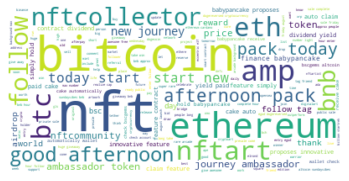

In [76]:
# 1st Word Cloud
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["the", "a", "are", "they", "in", "we", "is", "tweet","retweet", "feg", "fegarmy", "rt"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [77]:
eth_mask = np.array(Image.open("ETH.png"))
eth_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [78]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [79]:
# Transform your mask into a new one that will work with the function:
transformed_eth_mask = np.ndarray((eth_mask.shape[0],eth_mask.shape[1]), np.int32)

for i in range(len(eth_mask)):
    transformed_eth_mask[i] = list(map(transform_format, eth_mask[i]))

In [80]:
transformed_eth_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

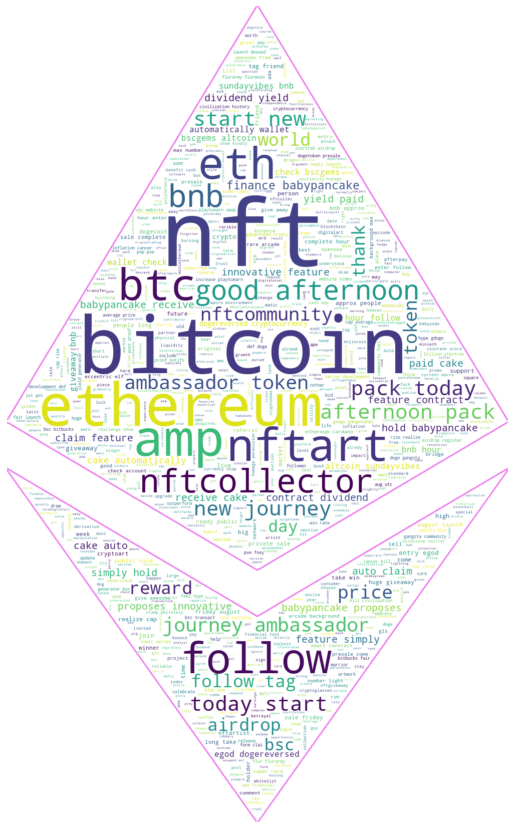

In [81]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_eth_mask,
               stopwords=stopwords, contour_width=3, contour_color='violet')

# Generate a wordcloud
wc.generate(text)

# store to file
wc.to_file("output.png")

# show
plt.figure(figsize=[30,15])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()